In [322]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [328]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size=32, labels=None, shuffle=True, sample_size=None):
        self.batch_size = batch_size
        self.dir = directory
        self.shuffle = shuffle
        self.sample_size = sample_size
        self._files = self.__get_images_from_directory(directory)
        self.on_epoch_end()

    def __len__(self):
        return len(self._files) // self.batch_size

    def __getitem__(self, index):
        batch = self._files[index*self.batch_size:index*self.batch_size+self.batch_size]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self._files)
        
        
    def __get_data(self, batch):
        X = np.empty((self.batch_size, 128, 512, 1))

        for i, file in enumerate(batch):
            path = self.dir + file
            img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
            scale = 1./255
            X[i,] = tf.convert_to_tensor(scale*np.array(tf.keras.preprocessing.image.img_to_array(img))) 
            
        y = X

        return X, y
    
    def iter(self, num):
    
        return self.__getitem__(num)
    
    def __get_images_from_directory(self, directory):
        files = os.listdir(directory)
        if self.shuffle:
            shuffle(files)t
        
        if self.sample_size != None:
            files = sample(files, self.sample_size)
        
        return files

In [370]:
test_gen = DataGenerator(directory='data/Spotify/pngs/', batch_size=32, sample_size=10000)

In [371]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Reshape, Conv2DTranspose, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

img_width = 512
img_height = 128
kernel_size = (5,5)
strides = (2,2)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=65536, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,32,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=1, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
class Autoencoder2(tf.keras.Model):
    
    def __init__(self, latent_dim):
        super(Autoencoder2, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, 1), filters=32, kernel_size=kernel_size, padding="same", activation='relu'),
            MaxPool2D(pool_size=strides),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", activation='relu'),
            MaxPool2D(pool_size=strides),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", activation='relu'),
            MaxPool2D(pool_size=strides),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same", activation='relu'),
            MaxPool2D(pool_size=strides),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim,)
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=65536, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(8,32,256)),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, padding="same", activation="relu"),
            UpSampling2D(size=strides),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, padding="same", activation="relu"),
            UpSampling2D(size=strides),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  padding="same", activation="relu"),
            UpSampling2D(size=strides),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  padding="same", activation="relu"),
            UpSampling2D(size=strides),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=1, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(256)
autoencoder2 = Autoencoder2(256)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [369]:
for layer in autoencoder.layers:
    for sublayer in layer.layers:
        print(sublayer.output_shape)

(None, 64, 256, 32)
(None, 64, 256, 32)
(None, 32, 128, 64)
(None, 32, 128, 64)
(None, 16, 64, 128)
(None, 16, 64, 128)
(None, 8, 32, 256)
(None, 8, 32, 256)
(None, 65536)
(None, 256)
(None, 65536)
(None, 65536)
(None, 8, 32, 256)
(None, 16, 64, 256)
(None, 16, 64, 256)
(None, 32, 128, 128)
(None, 32, 128, 128)
(None, 64, 256, 64)
(None, 64, 256, 64)
(None, 128, 512, 32)
(None, 128, 512, 32)
(None, 128, 512, 1)


In [394]:
hist = autoencoder.fit(test_gen, batch_size=32, epochs=10)

Epoch 1/10
312/312 [==============================] - 805s 3s/step - loss: 0.0152
Epoch 2/10
270/312 [========================>.....] - ETA: 1:48 - loss: 0.0149

KeyboardInterrupt: 

(128, 512)


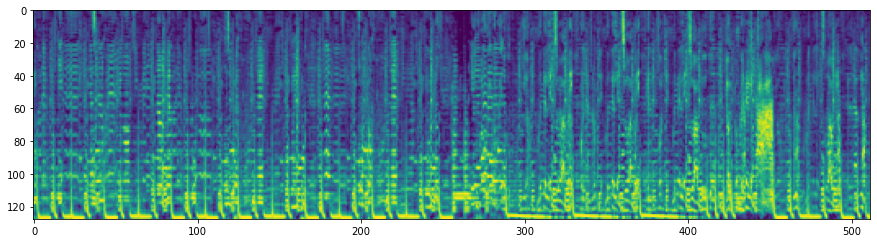

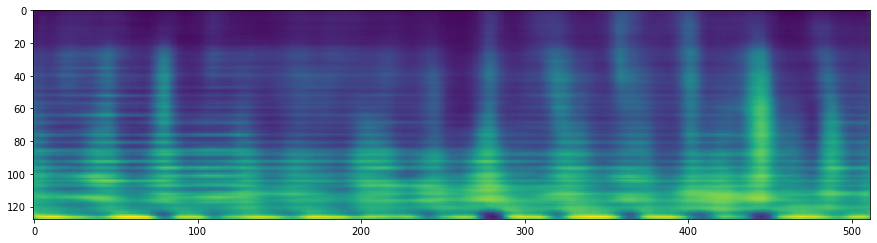

In [403]:
base_path = 'data/Spotify/pngs/'
files = os.listdir(base_path)

test_img = np.array(Image.open(base_path + files[345]))
test_img = test_img * 1./255
print(test_img.shape)
test_img_reshape = test_img.reshape(1, img_height, img_width, 1)

prediction = autoencoder(test_img_reshape)

plt.figure(figsize=(15,5))
plt.imshow(test_img)
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(np.array(prediction[0]*255))

In [404]:
autoencoder.save('data/autoencoder1')

INFO:tensorflow:Assets written to: data/autoencoder1/assets


INFO:tensorflow:Assets written to: data/autoencoder1/assets


In [376]:
autoencoder2.compile(optimizer='rmsprop', loss=tf.keras.losses.mse)

In [377]:

hist2 = autoencoder2.fit(test_gen, batch_size=32, epochs=10)

Epoch 1/10
312/312 [==============================] - 1651s 5s/step - loss: 0.0274
Epoch 2/10
312/312 [==============================] - 2550s 8s/step - loss: 0.0208
Epoch 3/10
312/312 [==============================] - 2608s 8s/step - loss: 0.0198
Epoch 4/10
312/312 [==============================] - 2605s 8s/step - loss: 0.0194
Epoch 5/10
312/312 [==============================] - 2647s 8s/step - loss: 0.0190
Epoch 6/10
312/312 [==============================] - 2648s 8s/step - loss: 0.0187
Epoch 7/10
312/312 [==============================] - 2653s 9s/step - loss: 0.0184
Epoch 8/10
312/312 [==============================] - 2663s 9s/step - loss: 0.0183
Epoch 9/10
312/312 [==============================] - 2654s 9s/step - loss: 0.0181
Epoch 10/10
312/312 [==============================] - 2673s 9s/step - loss: 0.0178


(128, 512)


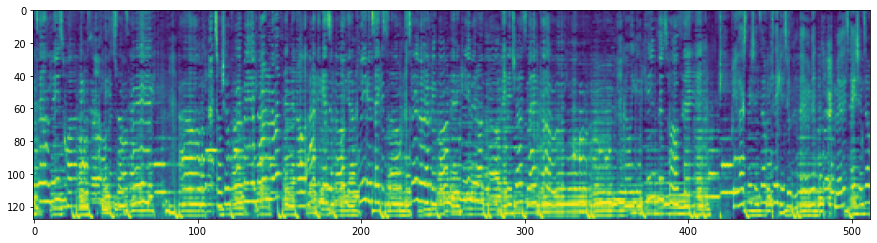

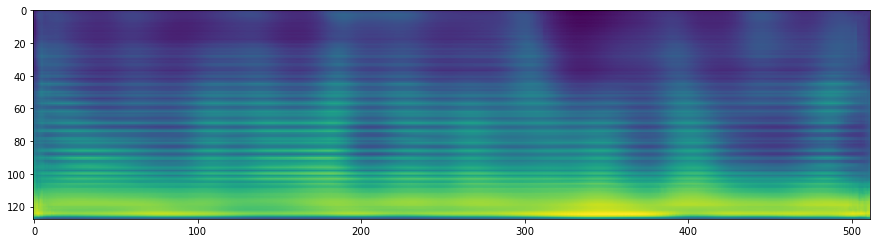

In [393]:
base_path = 'data/Spotify/pngs/'
files = os.listdir(base_path)

test_img = np.array(Image.open(base_path + files[6788]))
test_img = test_img * 1./255
print(test_img.shape)
test_img_reshape = test_img.reshape(1, img_height, img_width, 1)

prediction = autoencoder2(test_img_reshape)

plt.figure(figsize=(15,5))
plt.imshow(test_img)
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(np.array(prediction[0]*255))